# Energy A.I. Hackathon 2024 Workflow - Tigris Mendez

This project was done after the Hackathon event a learning exercise, referencing my team's project and the winning teams project.

## Executive Summary



1.   Our task was to predict the Average Pump Difference using features given in a dataset.
2.   Most important features we choosen with XGBoost's important() method
3.   I learned how important domain expertise can be and how a simple model like linear regression can reveal alot about a small dataset.
4.   





---

##Goal
Predict Average Pump Difference accurately with the given data



---



##Workflow

1. Data Preprocessing
2. Feature Selection
3. Imputation
4. Model Selection
5. Uncertainty Model



#Import Packages

In [155]:
!pip install scikit-learn xgboost

In [ ]:
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

##Read-in Hackathon Dataset

In [157]:
df = pd.read_csv('/content/HackathonData2024.csv')

In [158]:
df.head()

,Well ID,Avg Pump Difference,Area,Lateral Length,Fluid System,TVD,Development Strategy,DELAYED,BOUND_CODE,CODEV_POSITION,...,CODEV_3000_AVG_TVD_DIST,CODEV_3000_AVG_WELL_AGE,CODEV_3000_MEDIAN_WELL_AGE,CODEV_3000_WELL_COUNT,Pressure Gradient (psi/ft) new,Soak Time,Avg Open Pressure,SD Open Pressure,Avg Close Pressure,SD Close Pressure
0,1,-0.93,Acadia,10300,Campbell,10415.0,Coke,1,11100000,Edge,...,4,0.0,0.0,1,0.593758,34,3304.124833,261.7,2719.898438,472.4
1,2,-8.45,Acadia,10300,Campbell,10415.0,Coke,1,11100000,Edge,...,4,0.0,0.0,1,0.597059,67,3301.199254,255.9,2934.885325,747.4
2,3,8.70,Arches,11000,Campbell,8470.0,Orange Crush,0,101111,Middle,...,682,4.5,0.0,11,0.516873,34,2774.407080,184.8,1589.948673,596.9
3,4,NaN,Arches,11000,Campbell,10555.0,Coke,1,11110000,Edge,...,4,0.0,0.0,1,0.501287,30,2653.539415,206.7,1304.162878,551.5
4,5,19.93,Badlands,2300,Campbell,9295.0,Mountain Dew,1,10001101,Edge,...,277,1.0,1.0,2,0.503327,336,NaN,NaN,NaN,NaN


####Runing a type check to make sure all variables are types we can perform analysis on.

In [159]:
column_data_types = {}

for column in df.columns:
    data_type = df[column].dtype
    column_data_types[column] = str(data_type)

print("Column Data Types:")

for column, data_type in column_data_types.items():
    print(f"{column}: {data_type}")

Column Data Types:
Well ID: int64
Avg Pump Difference: float64
Area: object
Lateral Length: int64
Fluid System: object
TVD: float64
Development Strategy: object
DELAYED: int64
BOUND_CODE: int64
CODEV_POSITION: object
CODEV_FORMATION_POSITION: object
PARENT_CODEV_1050_WELL_COUNT: int64
PARENT_IN_ZONE_MIN_HYPOT: float64
PARENT_OUT_ZONE_MIN_HYPOT: float64
PARENT_IN_ZONE_MIN_MAP_DIST: float64
PARENT_OUT_ZONE_MIN_MAP_DIST: float64
PARENT_1050_AVG_WELL_AGE: float64
PARENT_1050_MEDIAN_WELL_AGE: float64
PARENT_1050_WELL_COUNT: int64
PARENT_3000_AVG_HYPOT_DIST: float64
PARENT_3000_AVG_MAP_DIST: float64
PARENT_3000_AVG_TVD_DIST: float64
PARENT_3000_AVG_WELL_AGE: float64
PARENT_3000_MEDIAN_WELL_AGE: float64
PARENT_3000_WELL_COUNT: int64
CODEV_IN_ZONE_MIN_HYPOT: float64
CODEV_OUT_ZONE_MIN_HYPOT: float64
CODEV_IN_ZONE_MIN_MAP_DIST: float64
CODEV_1050_WELL_COUNT: int64
CODEV_3000_AVG_HYPOT_DIST: int64
CODEV_3000_AVG_MAP_DIST: int64
CODEV_3000_AVG_TVD_DIST: int64
CODEV_3000_AVG_WELL_AGE: float64
CODE

# Data Preprocessing

Right off the bat. The "Area" feature adds too much complexity with it's various locaitons. This decreases the accuracy. So, we will remove the feature.

In [160]:
df = df.drop(columns='Area')

####Drop ID and Response var

*Because this data has categorical and numerical data types, we will one-hot encode the data to make them one-hot vectors. This will make all of the data numerical.*




**Our Categorical features are the following:**





In [161]:
# categorical_variables = df.select_dtypes(include='object').columns.tolist()

# print("Categorical Variable Names:")
# for var in categorical_variables:
#     print(var)

In [162]:
categorical_columns = ["Fluid System", "Development Strategy", "CODEV_POSITION", "CODEV_FORMATION_POSITION"]
one_hot_df = pd.concat([df] + [pd.get_dummies(df[col], drop_first = True) for col in categorical_columns], axis=1).drop(columns=categorical_columns)

####'BOUND_CODE' :

The Hackathon organizers gave us a description of the feature named 'BOUND_CODE' which desibes the area plot around a well and whether a well exist in that area or not. Because of this unique data type, it was important to maintain the information present by one-hot encoding converting each BOUND into a seperate section variable.

In [163]:
# Bound code zone:
#
#  +---+---+---+
#  | 1 | 2 | 3 |
#  +---+---+---+
#  | 4 |   | 5 |
#  +---+---+---+
#  | 6 | 7 | 8 |
#  +---+---+---+
#
#  Example BOUND_CODE : 11100000

*This code chunk below was from the winning team: "BevoBaddies"*






In [164]:
out = []

for k, code in enumerate(df['BOUND_CODE']):
  code_str = str(code).rjust(8, '0')
  tmp = []
  for i in range(8):
    tmp.append(int(code_str[i]))
  out.append(tmp)

out = np.transpose(out)

for i in range(len(out)):
  one_hot_df[f'BOUND_CODE_{i}'] = pd.Series(out[i])

# Now we do not need the BOUND_CODE column

one_hot_df = one_hot_df.drop(columns=["BOUND_CODE"])

starting_features = one_hot_df.drop(columns=["Avg Pump Difference", "Well ID"])
y = one_hot_df["Avg Pump Difference"]



*   We will drop Well ID because it is not a feature here
*   We will drop Avg Pump Difference because it is our response variable





---



##Data Imputation

####Data Incompleteness
Our data has some missing values, we want to know how much.

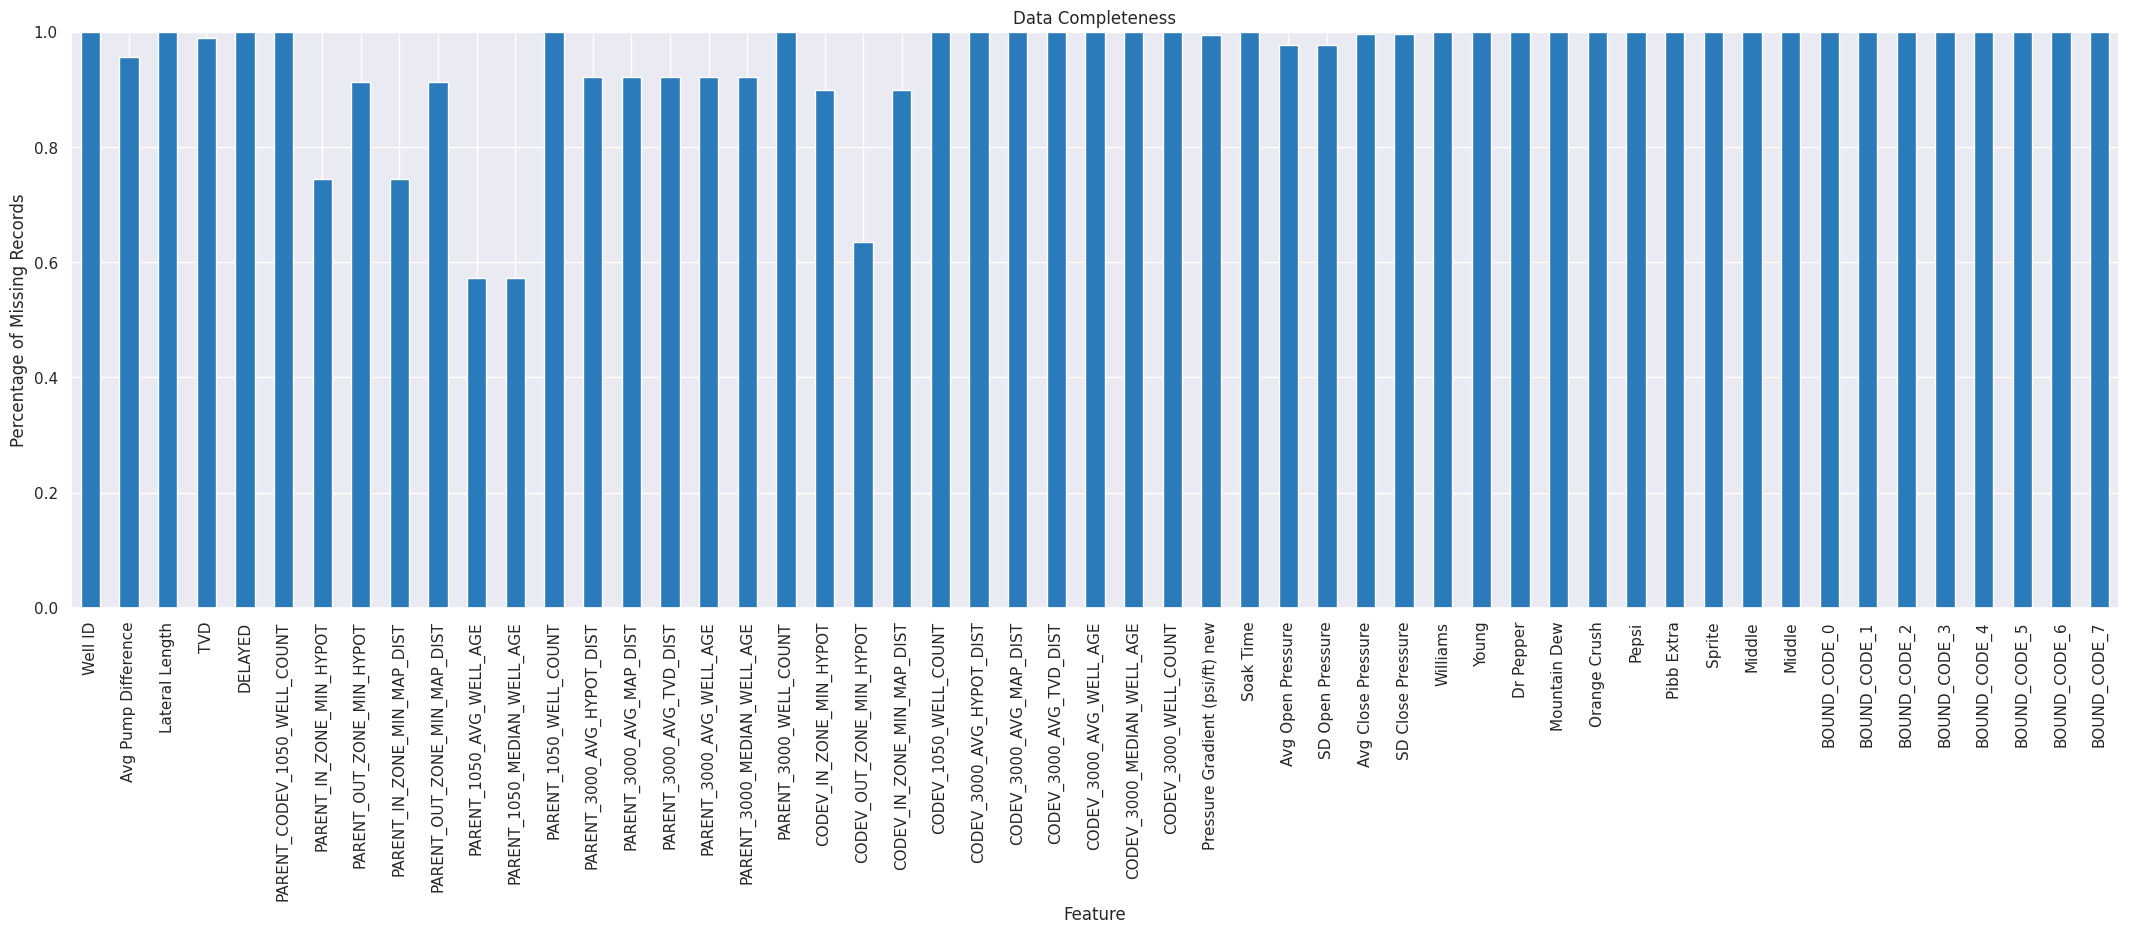

In [165]:
df_completeness = 1 - one_hot_df.isnull().sum() / len(one_hot_df)

# Plotting
blue_color = sns.color_palette("Blues")[4]  # You can adjust the index to choose a different shade of blue
df_completeness.plot(kind='bar', color=blue_color)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2)  # plot formatting
plt.xlabel('Feature')
plt.ylabel('Percentage of Missing Records')
plt.title('Data Completeness')
plt.ylim([0, 1.0])
plt.show()

###Should we remove the data incomplete features?
> Removing features could potentially remove valuable information during analysis, so we decided to perform EDA on the Five variables:


*   CODEV_OUT_ZONE_MIN_HYPOT
*   PARENT_1050_MEDIAN_WELL_AGE
*   PARENT_1050_AVG_WELL_AGE
*   PARENT_IN_ZONE_MIN_MAP_DIST
*   PARENT_IN_ZONE_MIN_HYPOT

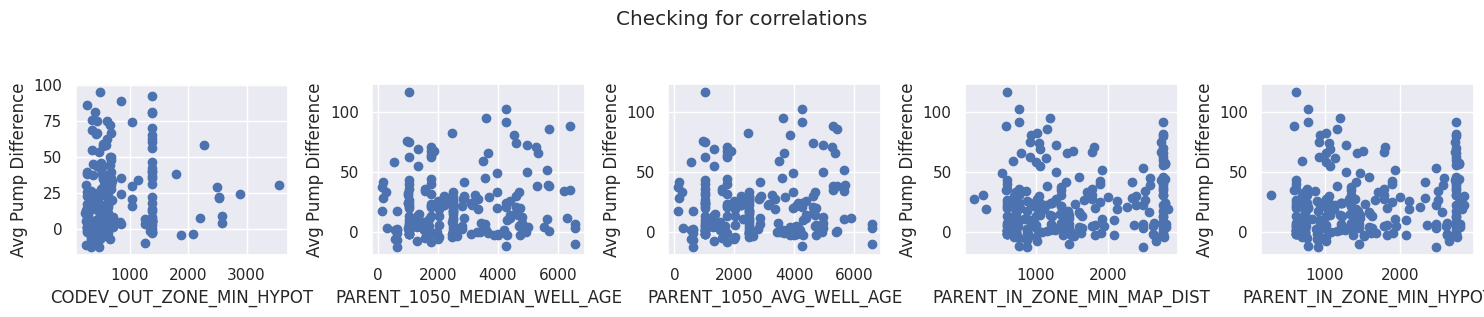

In [166]:
# Variables
variables = ['CODEV_OUT_ZONE_MIN_HYPOT', 'PARENT_1050_MEDIAN_WELL_AGE',
             'PARENT_1050_AVG_WELL_AGE', 'PARENT_IN_ZONE_MIN_MAP_DIST',
             'PARENT_IN_ZONE_MIN_HYPOT']

# Create a figure and subplots
fig, axs = plt.subplots(1, len(variables), figsize=(15, 3), sharey=False)

# Loop through variables and create subplots
for i, variable in enumerate(variables):
    axs[i].scatter(one_hot_df[variable], one_hot_df['Avg Pump Difference'])
    axs[i].set_xlabel(variable)
    axs[i].set_ylabel('Avg Pump Difference')

# Add a common title to the entire figure
fig.suptitle('Checking for correlations', y=1.05)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Display the plot
plt.show()


Due to these features not having any immedeately obvious correlations to the response variable. We will omit them.

In [167]:
new_df = one_hot_df.drop(columns=variables)

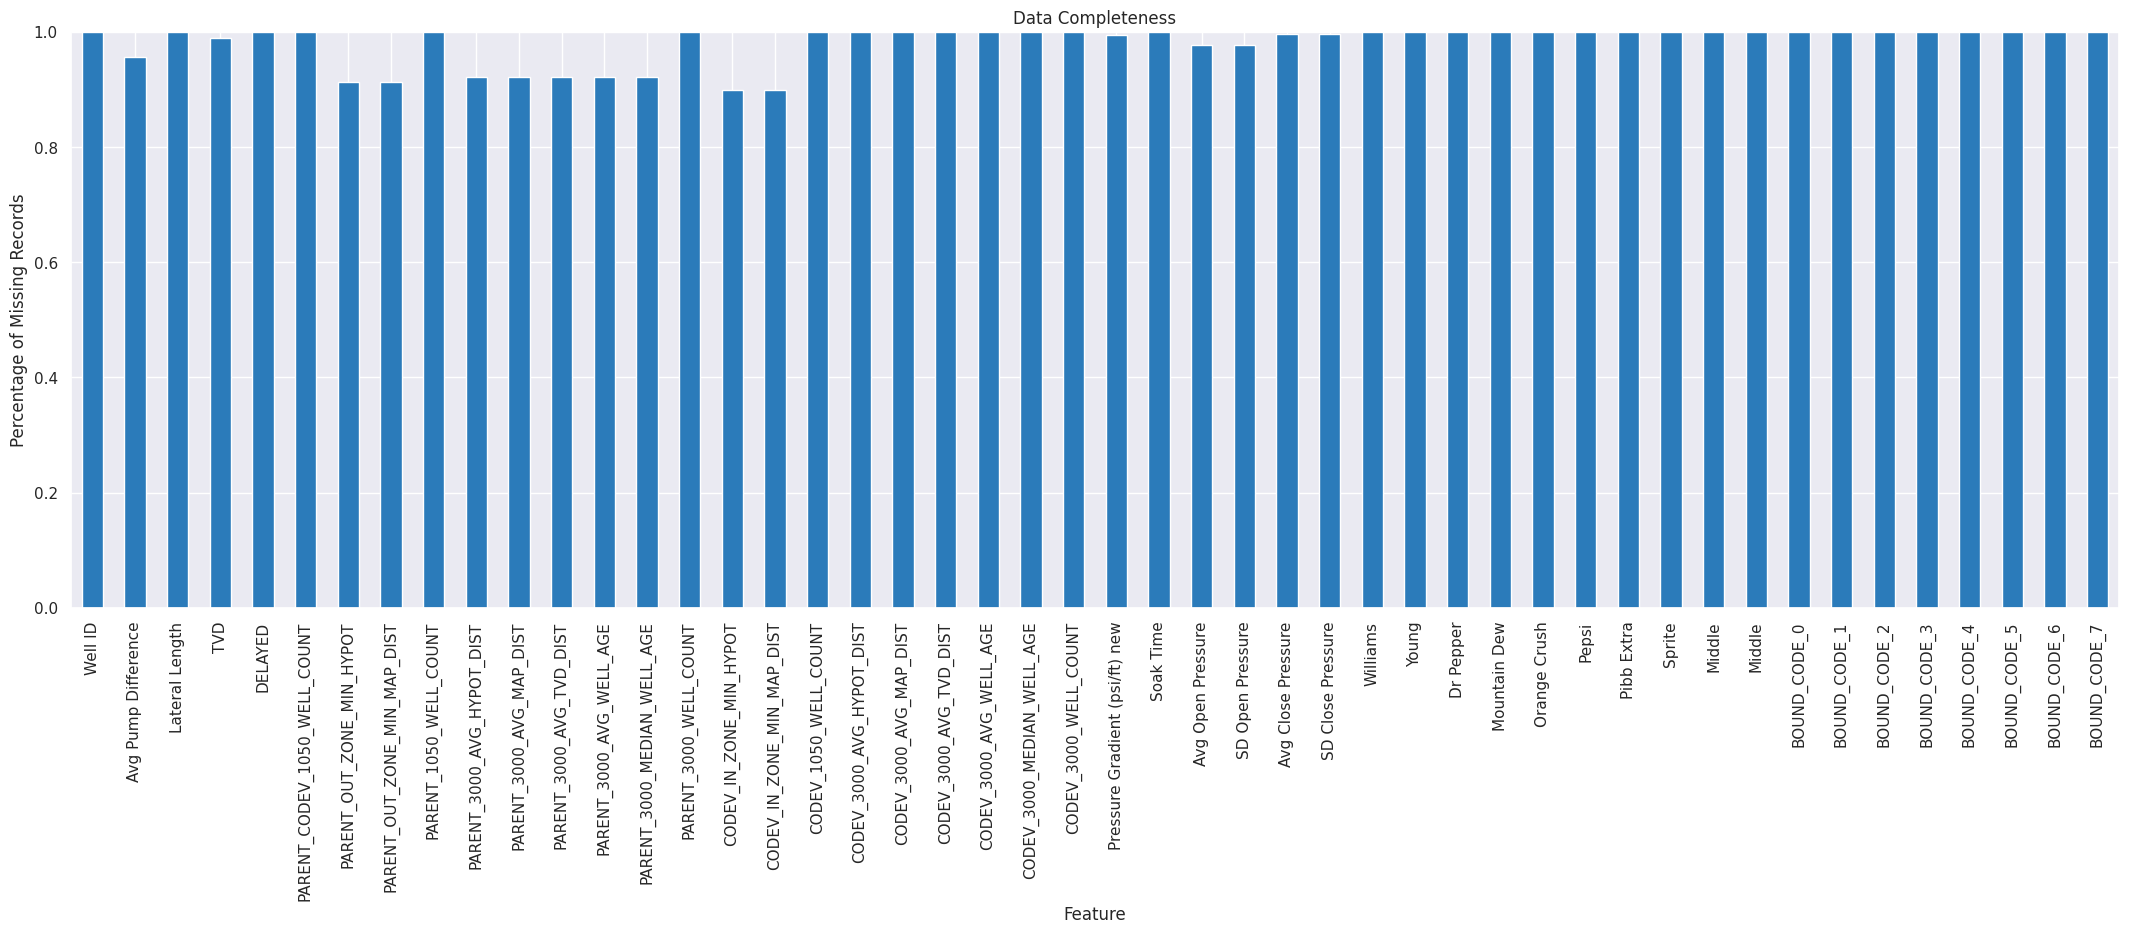

In [168]:
df_completeness = 1 - new_df.isnull().sum() / len(new_df)

# Plotting
blue_color = sns.color_palette("Blues")[4]  # You can adjust the index to choose a different shade of blue
df_completeness.plot(kind='bar', color=blue_color)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2)  # plot formatting
plt.xlabel('Feature')
plt.ylabel('Percentage of Missing Records')
plt.title('Data Completeness')
plt.ylim([0, 1.0])
plt.show()


The rest of the data looks mostly complete, so we will perform KNN imputation to complete it.

## Data Imputation

I will be using the ***K-Nearest Neighborhood*** method to perform data imputation



In [169]:
Before_imputation = starting_features
imputer = KNNImputer(n_neighbors=2)
After_imputation = imputer.fit_transform(Before_imputation)
imputated_df = pd.DataFrame(After_imputation, columns=starting_features.columns)

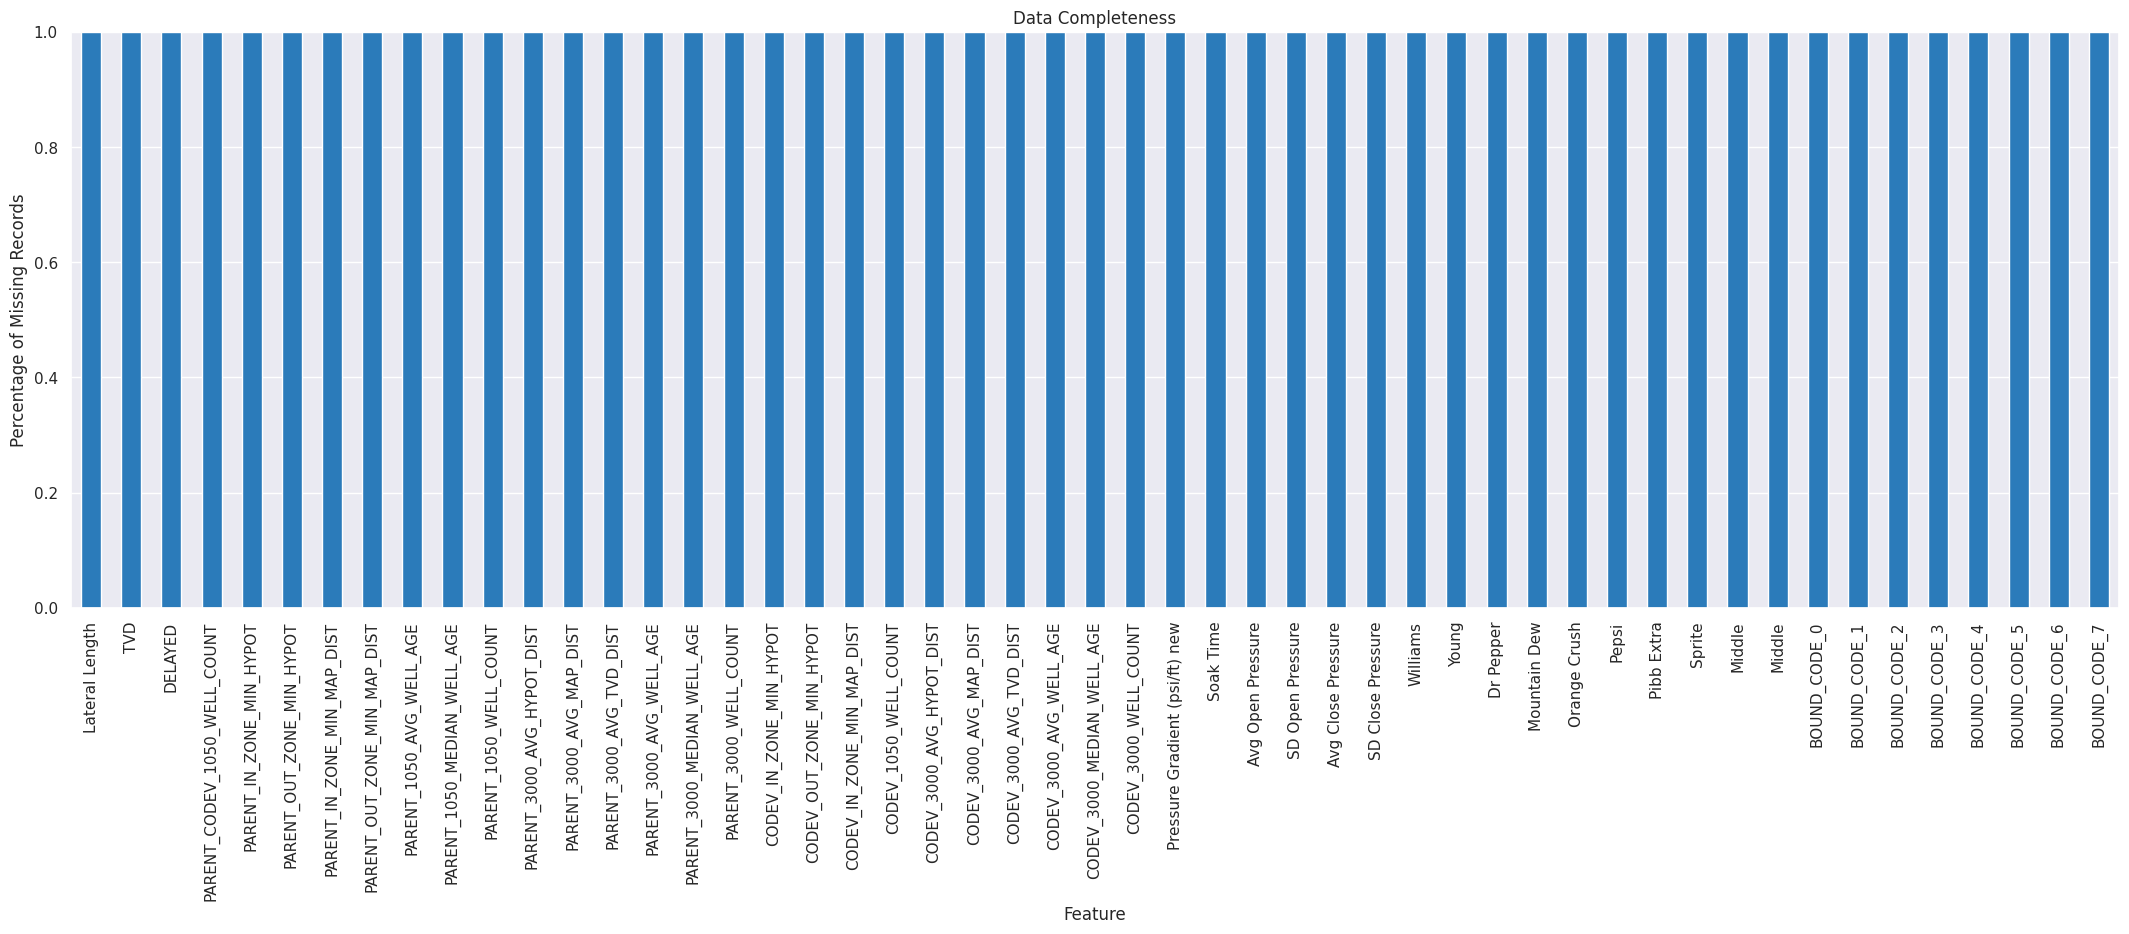

In [170]:
df_completeness_new = 1 - imputated_df.isnull().sum() / len(imputated_df)

# Plotting
blue_color = sns.color_palette("Blues")[4]  # You can adjust the index to choose a different shade of blue
df_completeness_new.plot(kind='bar', color=blue_color)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2)  # plot formatting
plt.xlabel('Feature')
plt.ylabel('Percentage of Missing Records')
plt.title('Data Completeness')
plt.ylim([0, 1.0])
plt.show()


## Feature Selection

### Collinearity heatmap
A collinearity heatmap informs us which independent variables move in relation to one another. For our numerical values, it is imperitive that we perform a collinearity. Yet, because we one-hot encoded our cateogrical data, we don't need to worry about it.

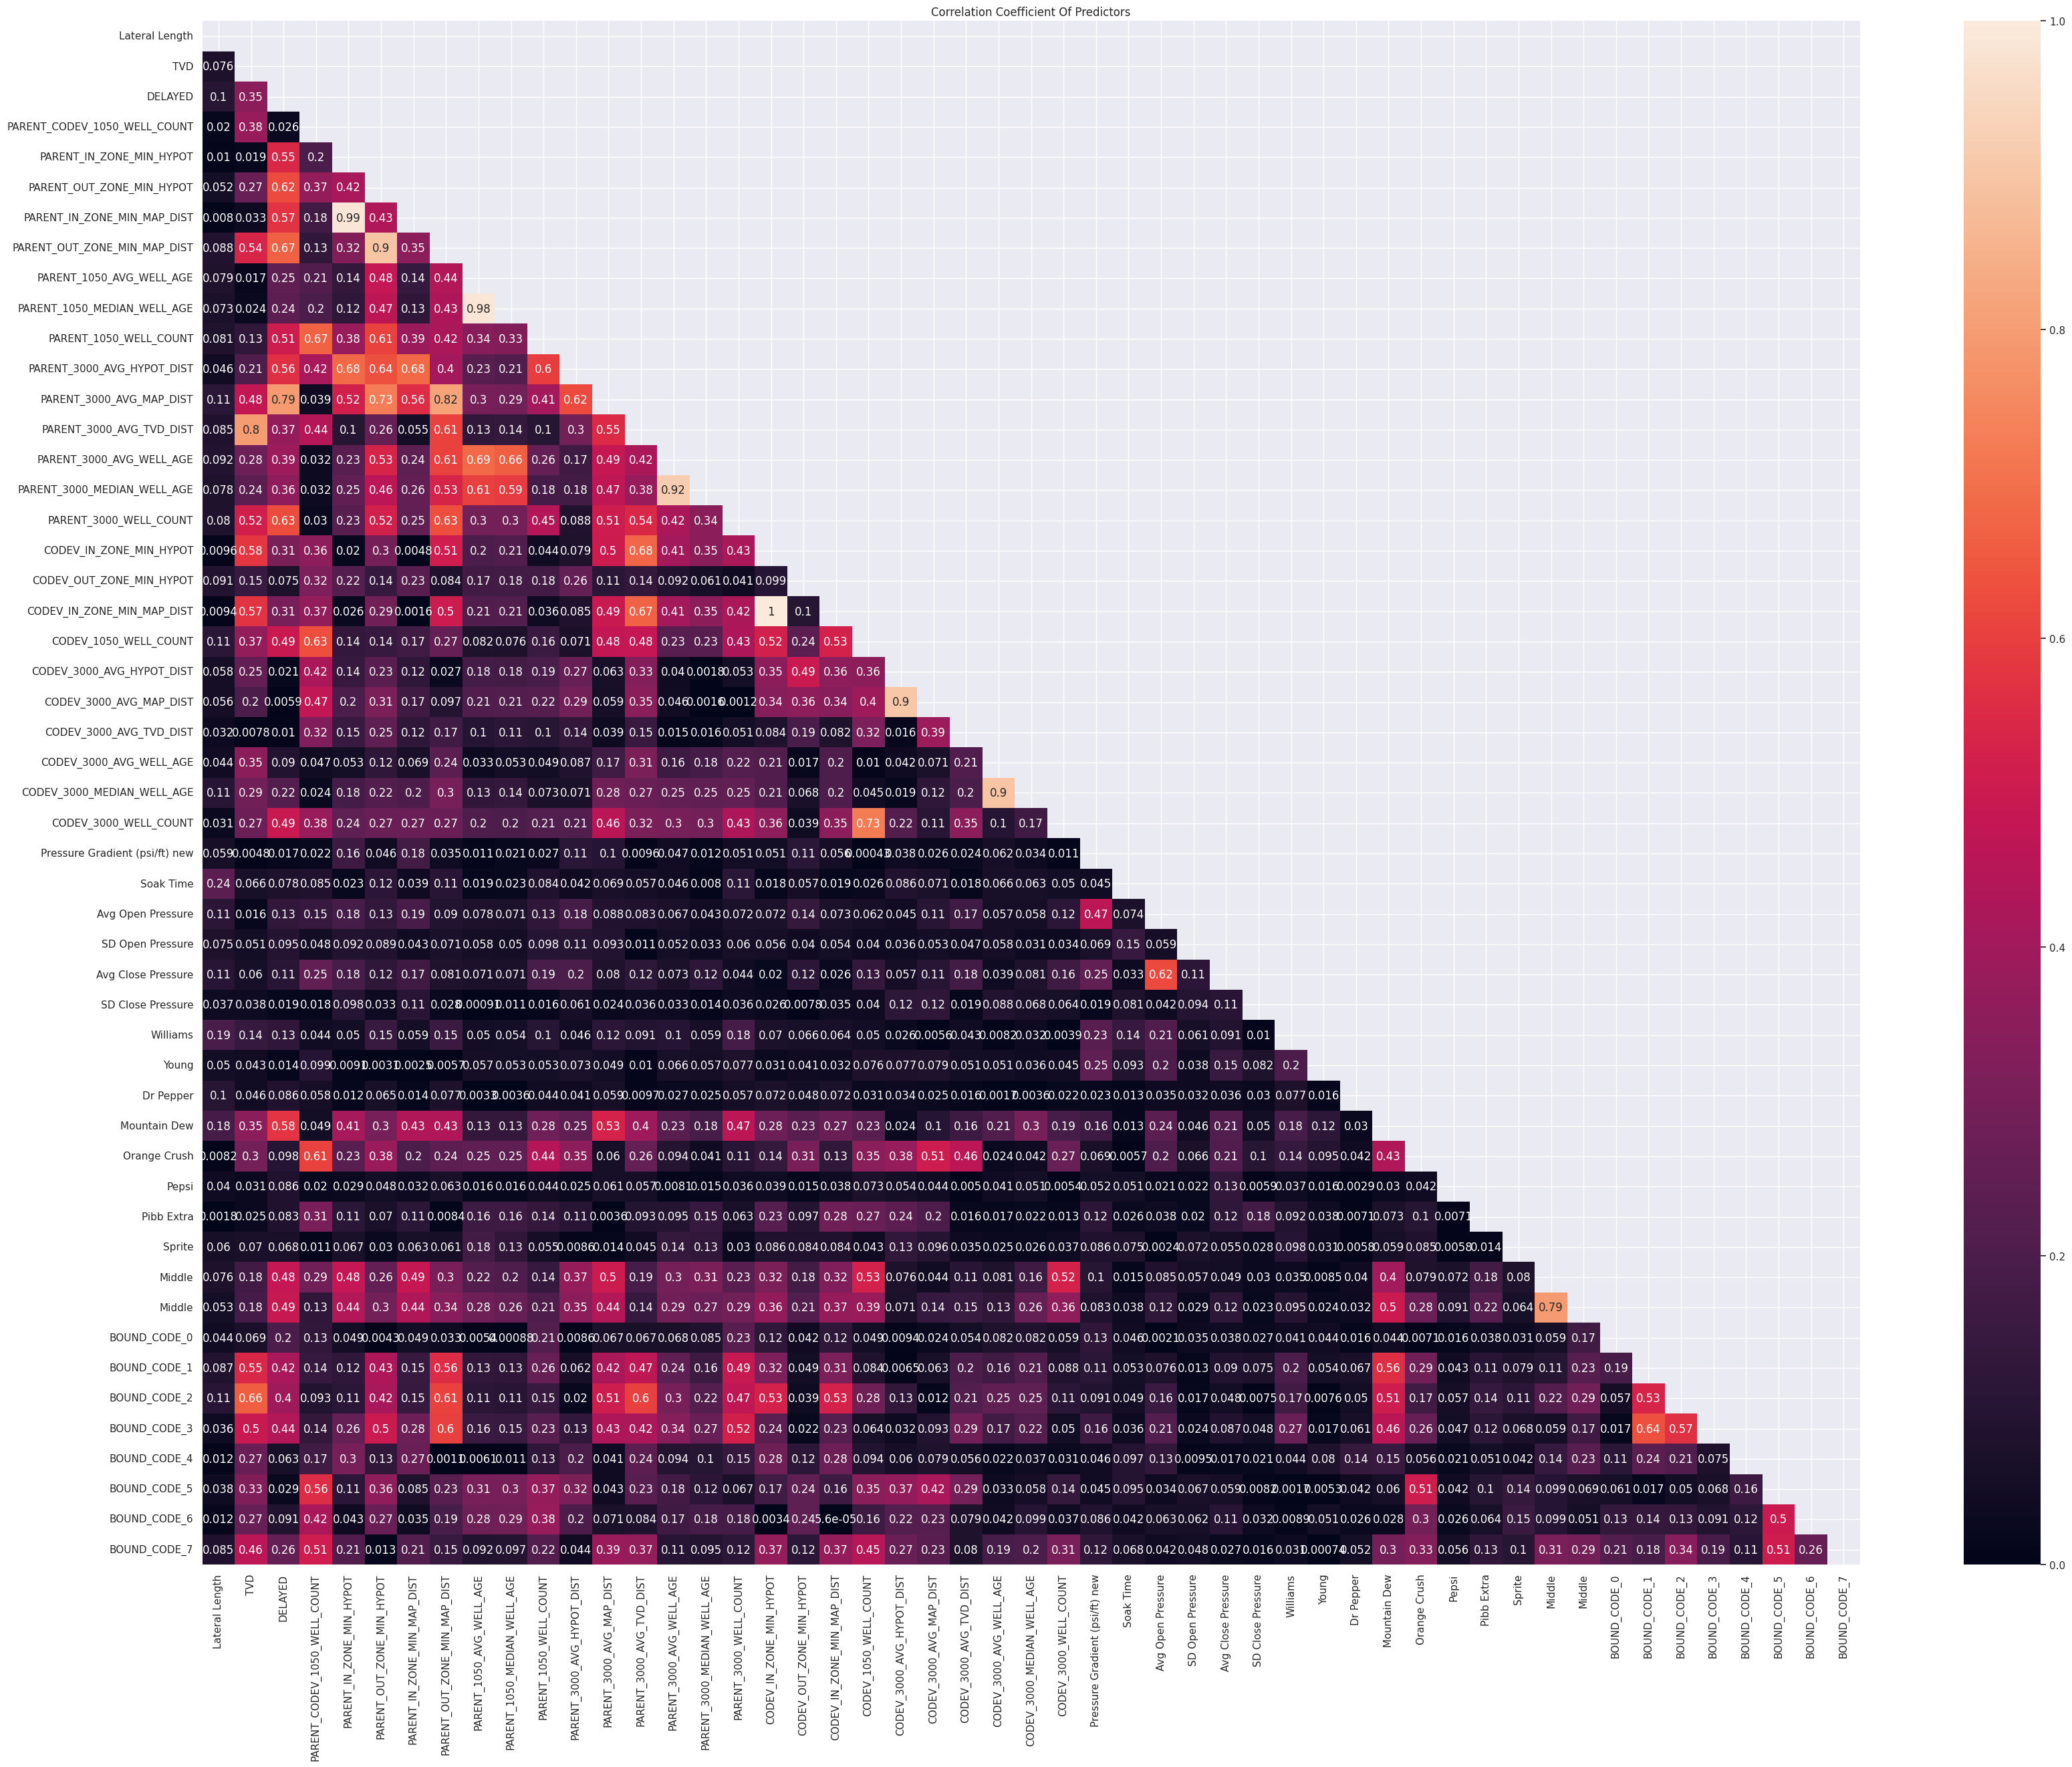

In [171]:
# set figure size
plt.figure(figsize=(40,30))


# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(imputated_df.corr(), dtype=bool))

# generate heatmap
sns.heatmap(abs(imputated_df.corr()), annot=True, mask=mask, vmin=0, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

Features I decided to remove:

> Bound Code: because the position of a well and it's presence would be homogenous in it's effect on average pump difference.

Removed because of colinear redundancy:


> PARENT_IN_ZONE_MIN_MAP_DIST


> PARENT_3000_MEDIAN_WELL_AGE


> CODEV_IN_ZONE_MIN_MAP_DIST


> CODEV_3000_AVG_MAP_DIST


> CODEV_3000_MEDIAN_WELL_AGE


> PARENT_OUT_ZONE_MIN_MAP_DIST


> PARENT_1050_MEDIAN_WELL_AGE





















In [172]:
removed = [
  'BOUND_CODE_0',
  'BOUND_CODE_1',
  'BOUND_CODE_2',
  'BOUND_CODE_3',
  'BOUND_CODE_4',
  'BOUND_CODE_5',
  'BOUND_CODE_6',
  'BOUND_CODE_7',
  'Middle',
  'PARENT_IN_ZONE_MIN_MAP_DIST',
  'PARENT_3000_MEDIAN_WELL_AGE',
  'CODEV_IN_ZONE_MIN_MAP_DIST',
  'CODEV_3000_AVG_MAP_DIST',
  'CODEV_3000_MEDIAN_WELL_AGE',
  'PARENT_OUT_ZONE_MIN_MAP_DIST',
  'PARENT_1050_MEDIAN_WELL_AGE'
]

imputated_df = imputated_df.drop(columns=removed)

Checking correlations between the Xs and Y

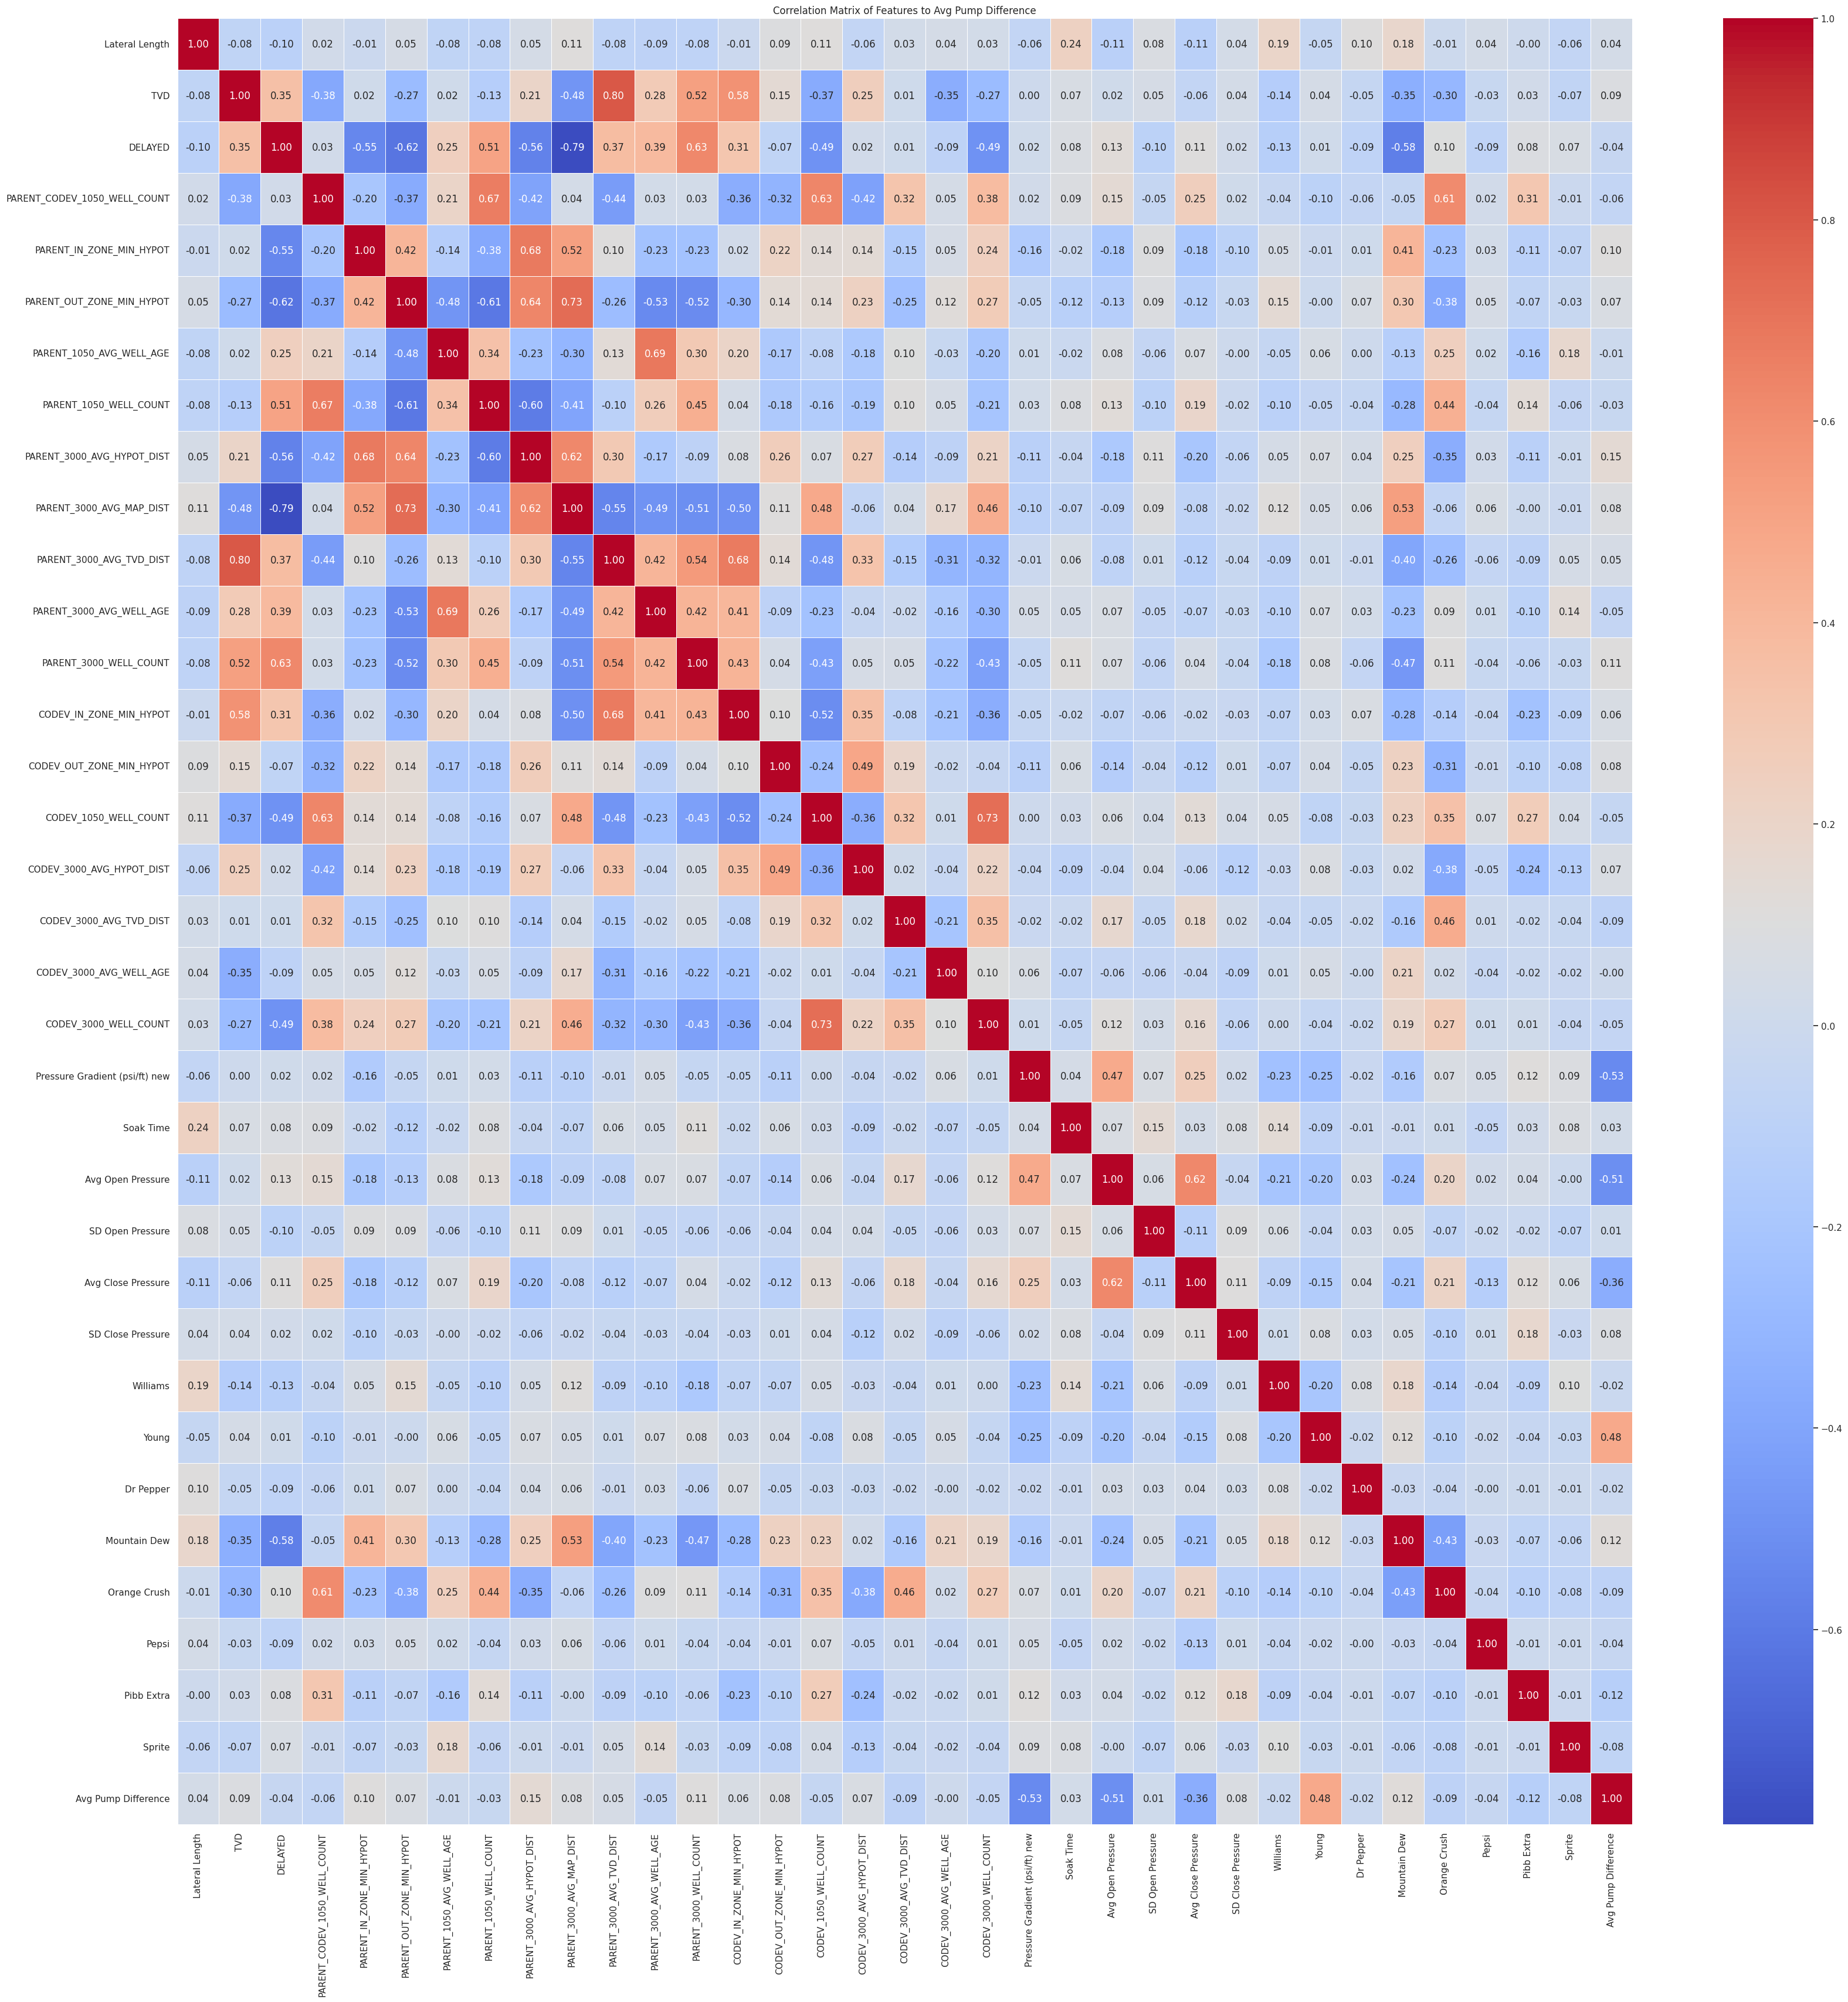

In [173]:
imputated_df = pd.concat([imputated_df, y], axis=1)

# Assuming 'df' is your DataFrame and 'response_variable' is the column you want to correlate
response_variable = 'Avg Pump Difference'  # Replace 'target_column' with the actual name of your response variable
correlation_matrix = imputated_df.corr()

# Create a matrix of scatterplots
plt.figure(figsize=(40, 40))
sns.set(font_scale=1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title(f'Correlation Matrix of Features to {response_variable}')
plt.show()



**Percentage of rows which are missing target variable**

In [174]:
missing_percentage = imputated_df['Avg Pump Difference'].isnull().mean()*100
print(missing_percentage, '%')

4.310344827586207 %


**Removed rows with missing target variable values**

In [175]:
imputated_df = imputated_df.dropna(subset=['Avg Pump Difference'])

##Linear Regression

*Select Variables*

In [193]:
X = imputated_df.drop('Avg Pump Difference', axis = 1)
y = imputated_df['Avg Pump Difference']

*Split train and test datasets*

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train.shape, X_test.shape

((249, 34), (84, 34))

###Regression Model

In [178]:
model = xgb.XGBRegressor()  # You can customize XGBoost parameters here

In [179]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Checking Feature Importance

*** ChatGPT Assisted ***

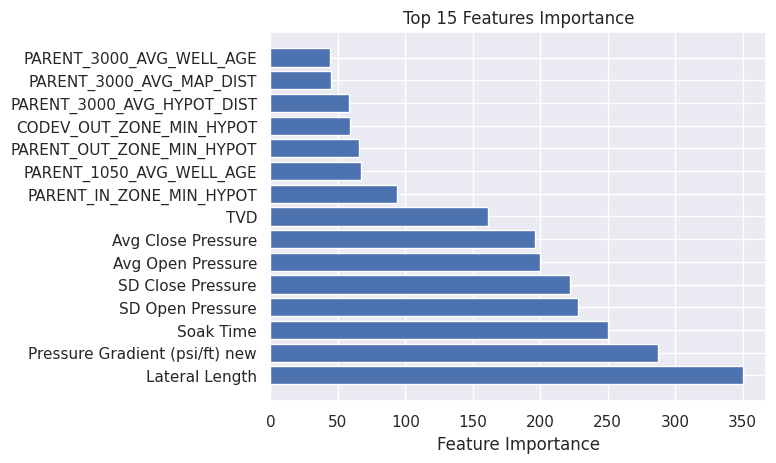

In [196]:
import matplotlib.pyplot as plt

# Assuming your model is a Pipeline with 'regressor' as the XGBoost step
xgb_regressor = model

# Get the booster from the XGBoost regressor
booster = xgb_regressor.get_booster()

# Get feature importance scores
importance = booster.get_score(importance_type='weight')

# Sort features by importance and get the top 15
top_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:15]

# Extract feature names and importance values
top_feature_names = [feature[0] for feature in top_features]
top_feature_importance = [feature[1] for feature in top_features]

# Plot feature importance for the top 15 features
plt.barh(range(15), top_feature_importance, align='center')
plt.yticks(range(15), top_feature_names)
plt.xlabel('Feature Importance')
plt.title('Top 15 Features Importance')
plt.show()


###We will continue to select features down to the 8 most important

In [209]:
# removed_2 = [
#     'TVD',
#     'Avg Close Pressure',
#     'Avg Open Pressure',
#     'SD Close Pressure',
#     'SD Open Pressure',
#     'Soak Time',
#     'Pressure Gradient (psi/ft) new',
#     'Lateral Length',
#     'Avg Pump Difference'
# ]

removed_2 = [
    'Avg Close Pressure',
    'Avg Open Pressure',
    'SD Close Pressure',
    'SD Open Pressure',
    'Soak Time',
    'Pressure Gradient (psi/ft) new',
    'Lateral Length',
    'Avg Pump Difference'
]

imputated_df_2 = imputated_df.loc[:, imputated_df.columns.isin(removed_2)]

imputated_df_2.head()

,Lateral Length,Pressure Gradient (psi/ft) new,Soak Time,Avg Open Pressure,SD Open Pressure,Avg Close Pressure,SD Close Pressure,Avg Pump Difference
0,10300.0,0.593758,34.0,3304.124833,261.7,2719.898438,472.4,-0.93
1,10300.0,0.597059,67.0,3301.199254,255.9,2934.885325,747.4,-8.45
2,11000.0,0.516873,34.0,2774.407080,184.8,1589.948673,596.9,8.70
4,2300.0,0.503327,336.0,3378.019923,233.2,2717.059211,509.3,19.93
5,12300.0,0.565200,21.0,2963.567911,232.0,2063.408619,517.8,-4.34


In [210]:
X = imputated_df.drop('Avg Pump Difference', axis = 1)
y = imputated_df['Avg Pump Difference']



In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train.shape, X_test.shape

((249, 34), (84, 34))

In [212]:
model = xgb.XGBRegressor()  # You can customize XGBoost parameters here

In [213]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

##Train Performance

In [214]:
pred_train = model.predict(X_train)

In [215]:
from sklearn.metrics import mean_squared_error, r2_score
print(r2_score(y_train, pred_train))

0.9999999618890798


In [216]:
print(mean_squared_error(y_train, pred_train))

2.2360203176015288e-05


Test Performance

0.4081044503456118
340.69524648745494


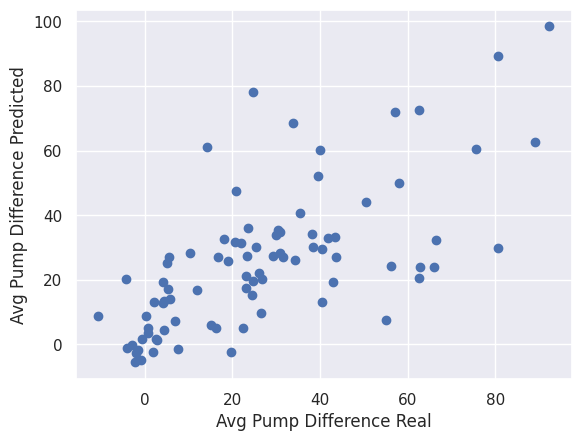

In [217]:
predictions = model.predict(X_test)

print(r2_score(y_test, predictions))

model.score(X_test, y_test)

print(mean_squared_error(y_test, predictions))

plt.scatter(y_test, predictions)
plt.xlabel("Avg Pump Difference Real")
plt.ylabel("Avg Pump Difference Predicted")
plt.show()

##Uncertainty Model

Calculating the uncertainty model